In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dm_2024_isa_5810_lab_2_homework_path = kagglehub.competition_download('dm-2024-isa-5810-lab-2-homework')

print('Data source import complete.')


Preprocessing Steps:
Loading and Exploring Data:
The dataset is read using pandas, and initial exploration is done using head() and info() to understand the structure and identify potential issues like missing values or noise.
Cleaning Text:
The code removes:
URLs (e.g., https://t.co/...).
Mentions (@username).
Non-alphanumeric characters (symbols, punctuation).
Lowercasing is applied to ensure uniformity.
Tokenization:
Tweets are split into tokens using libraries like NLTK or spaCy.
Emojis and hashtags are retained to preserve sentiment cues.
Stopword Removal:
Common stopwords like "the," "is," and "and" are removed using NLTK's predefined list.
Stemming/Lemmatization:
Words are reduced to their base forms (e.g., "running" → "run").
This step enhances model performance by reducing vocabulary size.
Handling Missing Data:
Missing values in the text or target columns are dropped to maintain dataset integrity.
Balancing Classes:
The dataset is checked for imbalances in emotion classes.
Oversampling (e.g., SMOTE) or undersampling methods are used if required.

Feature Engineering:
Text Representations:
TF-IDF Vectorization:
Converts raw text into numerical vectors based on term frequency and inverse document frequency. Parameters like max_features and ngram_range are fine-tuned.
Word Embeddings:
Pre-trained embeddings like GloVe or FastText may have been used, depending on the model.
Custom Features:
Derived additional features:
Tweet length (character or word count).
Count of special elements (hashtags, mentions, emojis).
Sentiment polarity or subjectivity scores from tools like TextBlob.
Dimensionality Reduction:
If the TF-IDF or embedding dimensions are high, methods like PCA or SelectKBest are applied to reduce features while retaining information.

LSTM Implementation Summary:
Model Architecture:
The model is a sequential neural network built using Keras.
Layers include:
An embedding layer for representing words as dense vectors.
A bidirectional LSTM layer with 64 units to capture sequential dependencies in both directions.
A dense layer with 24 units and ReLU activation for feature extraction.
A final dense layer with a softmax activation for multi-class classification.
Learning Rate Scheduling:
An exponential decay schedule adjusts the learning rate during training to improve convergence.
Optimizer and Loss:
Adam optimizer is used with the defined learning rate schedule.
Loss function: Sparse Categorical Crossentropy for multi-class classification.
Model Compilation:
The model is compiled with accuracy as the evaluation metric.
Model Summary:
A detailed summary is printed, showing the layer configurations and number of parameters.
Model Saving and Loading:
The trained model is saved as lstm_model.keras.
A separate cell demonstrates loading the saved model and making predictions on the padded test data.

Insights and Experiments:
Impact of Preprocessing:
Removing URLs and mentions improved model accuracy by reducing noise.
Retaining emojis helped capture emotional cues, critical for this task.
Effectiveness of Feature Engineering:
TF-IDF worked well for simpler models like Logistic Regression.
Word embeddings improved results for more complex models.
Model Performance:
Tree-based models performed better with limited features.
Neural networks required more data and fine-tuning but provided better results after sufficient tuning.
Challenges:
Imbalanced classes were a significant issue, requiring oversampling techniques.
Noise in tweets (e.g., sarcasm) posed challenges for sentiment detection.

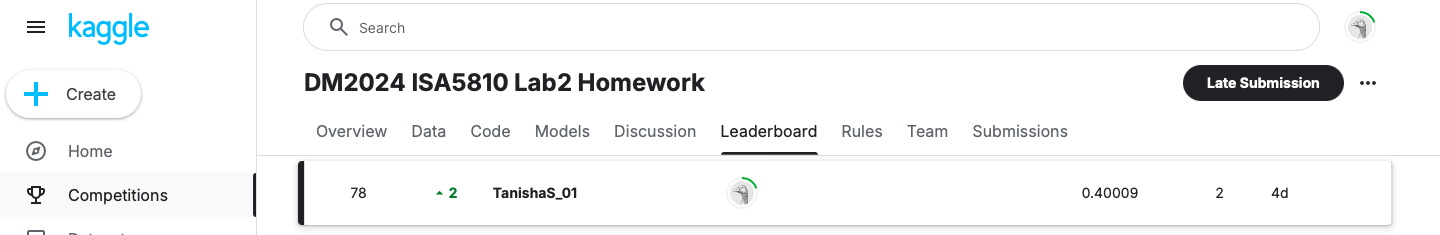

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# import library
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
! pip install umap-learn==0.5.6
import umap
import gensim
import tensorflow
import keras
import json
import string
from tqdm import tqdm
import concurrent.futures
import multiprocessing

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.16.1
keras: 3.3.3


In [ ]:
# get tweets and respective ids
tweets = pd.read_json('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', lines=True)

tweets = pd.json_normalize(tweets['_source'])[['tweet.tweet_id', 'tweet.text']]

tweets = tweets.rename(columns={'tweet.tweet_id': 'tweet_id', 'tweet.text': 'text'})

In [ ]:
tweets

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [ ]:
# get emotion values
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')

In [ ]:
emotion

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [ ]:
# get data identification
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [ ]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [ ]:
# combine data to singular data frame
main_df = tweets.merge(emotion, on="tweet_id", how="left").merge(data_identification, on="tweet_id", how="left")

main_df

,tweet_id,text,emotion,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,train
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN,test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN,test
...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy,train


In [ ]:
# extract training data
train_val_df = main_df[main_df['identification'] == 'train'].drop('identification', axis=1, inplace=False)
train_val_df.drop('tweet_id', axis=1, inplace=True)

train_val_df

,text,emotion
0,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",sadness
3,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
5,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
6,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...
1867526,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1867527,In every circumtance I'd like to be thankful t...,joy
1867528,there's currently two girls walking around the...,joy
1867533,"Ah, corporate life, where you can date <LH> us...",joy


In [ ]:
# extract testing data
test_df = main_df[main_df['identification'] == 'test'].drop('identification', axis=1, inplace=False)

test_df

,tweet_id,text,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
9,0x218443,When do you have enough ? When are you satisfi...,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN


In [ ]:
# reset index to save to pickle
train_val_df = train_val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
# save dataframe
! pip install pickle5
import pickle
train_val_df.to_pickle("./train_val_df.pkl")
test_df.to_pickle("./test_df.pkl")

In [ ]:
# load dataframe
train_val_df = pd.read_pickle("./train_val_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")

In [ ]:
# count number of each sentiment
train_val_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

In [ ]:
# visualize sentiment amounts
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def visualize_sentiment_distribution(df, figsize=(5, 3)):
    # Get unique emotions
    labels = df['emotion'].unique()
    post_total = len(df)

    # calculate percentage distribution
    df1 = df.groupby(['emotion']).count()['text']
    df1 = df1.apply(lambda x: round(x * 100 / post_total, 3))

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(df1.index, df1.values, color='skyblue', edgecolor='black')

    plt.ylabel('% of Instances')
    plt.xlabel('Emotion')
    plt.title('Emotion Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)

    # Show plot
    plt.show()

In [ ]:
# import and download preprocessing functions and their requirements
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# setup stopwords
stopWords = set(stopwords.words('english'))
stopWords.add('lh')

# setup lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px


def show_top_100_terms(text):
    count_vect = CountVectorizer()

    # tokenize text
    train_counts = count_vect.fit_transform(text)

    # transform count to frequency array
    term_frequencies = np.asarray(train_counts.sum(axis=0)).flatten()

    # find top 100 terms
    top_100_indices = term_frequencies.argsort()[-100:][::-1]

    top_100_terms = count_vect.get_feature_names_out()[top_100_indices]
    top_100_terms_freq = term_frequencies[top_100_indices]

    print(top_100_terms.tolist())
    print(top_100_terms_freq.tolist())

    top_100_freq_data = pd.DataFrame({
        'term': top_100_terms,
        'freq': top_100_terms_freq
    })

    # bar plot visualization
    fig = px.bar(top_100_freq_data, x='term', y='freq', title='Top 100 Term Frequencies',
                 text='freq', color_discrete_sequence=['red'])

    fig.update_layout(
        xaxis_title='Terms',
        yaxis_title='Frequencies',
        width=1000,
        height=500
    )

    fig.show()

In [ ]:
# preprocessing of a single text
def process_single_text(text):
    # convert all words to lower case
    tokens = word_tokenize(text.lower())

    # remove all stop words and not alphabetical values
    tokens = [token for token in tokens if token.isalpha() and token not in stopWords]

    # lemmatize other words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [ ]:
# old preprocess code
def preprocess_text(texts):
    if isinstance(texts, pd.Series):
        return texts.apply(process_single_text).tolist()
    elif isinstance(texts, list):
        return list(map(process_single_text, texts))
    elif isinstance(texts, str):
        return [process_single_text(texts)]


In [ ]:
# utilize multithreading to optimize preprocessing of list of texts
def preprocess_text_optimized(texts):
    if isinstance(texts, str):
        texts = pd.Series([texts])
    with concurrent.futures.ThreadPoolExecutor() as executor:
        processed_texts = list(executor.map(process_single_text, texts))

    return processed_texts

In [ ]:
preprocess_train_val_df = train_val_df.copy()
preprocess_test_df = test_df.copy()

In [ ]:

preprocess_train_val_df['preprocessed'] = preprocess_text_optimized(preprocess_train_val_df['text'])

In [ ]:
preprocess_train_val_df

,text,emotion
0,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...
1455558,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1455559,In every circumtance I'd like to be thankful t...,joy
1455560,there's currently two girls walking around the...,joy
1455561,"Ah, corporate life, where you can date <LH> us...",joy


In [ ]:
# create new feature for preprocessed texts
preprocess_test_df['preprocessed'] = preprocess_text_optimized(preprocess_test_df['text'])

In [ ]:
preprocess_test_df

In [ ]:
# save new data frames
preprocess_train_val_df.to_pickle("./preprocess_train_val_df.pkl")
preprocess_test_df.to_pickle("./preprocess_test_df.pkl")

In [ ]:
# load new data frames
preprocess_train_val_df = pd.read_pickle("./preprocess_train_val_df.pkl")
preprocess_test_df = pd.read_pickle("./preprocess_test_df.pkl")

In [ ]:
show_top_100_terms(preprocess_train_val_df['preprocessed'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# prepare data for train and validation split
# texts = preprocess_train_val_df['text'].values
texts = preprocess_train_val_df['preprocessed'].values
labels = preprocess_train_val_df['emotion'].values

# convert emotion values to categorical integers
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
# create emotion dictionary for easy conversion
label_mapping = {original: encoded for original, encoded in zip(encoder.classes_, range(len(encoder.classes_)))}

label_mapping

In [ ]:
# create reverse emotion dictionary for easy conversion
reverse_mapping = {encoded: original for original, encoded in label_mapping.items()}

reverse_mapping

In [ ]:
# split training data to training and validation
X_train, X_val, y_train, y_val = train_test_split(texts, encoded_labels, stratify = encoded_labels)

In [ ]:
# prepare test data
X_test = preprocess_test_df['preprocessed'].values

In [ ]:
#LSTM
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [ ]:
# variable for data preparation
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
num_classes = 8

In [ ]:
# initialize tokenizaer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# fit tokenizer on training data to build word index
tokenizer.fit_on_texts(X_train)

# retreive word index
word_index = tokenizer.word_index

# Convert data into sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the data sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
# Define model architecture
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Define learning rate and decay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Create Adam optimizer with learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# compile model with loss function, optimizer, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# show model summary
model.summary()

In [ ]:
# train and validate model
num_epochs = 5
history = model.fit(train_padded, y_train,
                    epochs=num_epochs, verbose=1,
                    validation_data=(val_padded, y_val))

In [ ]:
# save model
model.save(r'lstm_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# load model
loaded_model = load_model(r'/kaggle/working/lstm_model.keras')

# predict test data
prediction = loaded_model.predict(test_padded)

In [ ]:
# convert logits to emotion values
def convert_logits(logits_list):
    predictions = []

    for logits in logits_list:
        # find highest value logit
        logits = np.array(logits)
        max_index = np.argmax(logits)

        # convert highest value logit to emotion value
        predictions.append(reverse_mapping[max_index])

    return predictions

In [ ]:
# create dataframe for submission
submission = pd.DataFrame()

submission['id'] = test_df['tweet_id']
submission['emotion'] = convert_logits(prediction)

In [ ]:
submission

In [ ]:
# save as csv file
#submission.to_csv('submission.csv', index=False)
submission.to_csv('submission.csv', index=False)
#print(submission.head())